In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from compel import Compel, CompelForSDXL, ReturnedEmbeddingsType
from diffusers import DiffusionPipeline
import torch

device='mps'
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", variant="fp16", use_safetensors=True, torch_dtype=torch.float16).to(device)

compel = Compel(
    tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2],
    text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2],
    returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
    requires_pooled=[False, True],)
#compel = CompelForSDXL(pipeline)


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.63it/s]


Deprecation warning: passing multiple tokenizers/text encoders to Compel is deprecated and will be removed in v3.0 Use one of the CompelFor_ classes in multi_model_wrappers instead


In [ ]:
# upweight "ball"
prompt = "a cat playing with a ball++ in the forest"
negative_prompt = "deformed, ugly"
conditioning = compel([prompt, negative_prompt])
#print(conditioning[0].shape, conditioning[1].shape)


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


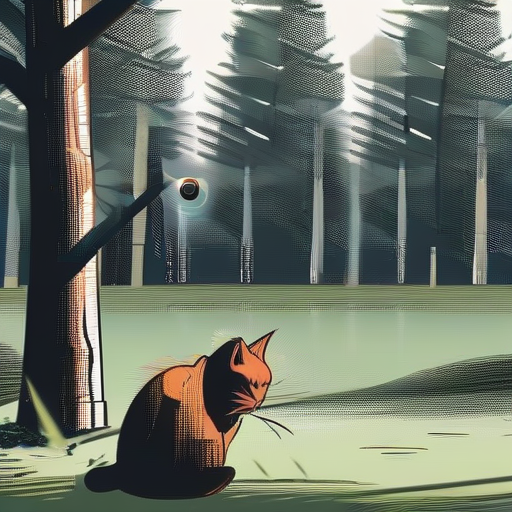

In [9]:
image = pipeline(prompt="A cat playing with a ball in the forest", negative_prompt="deformed, ugly",
                 num_inference_steps=10, width=512, height=512).images[0]
image

In [10]:
conditioning = compel(["A cat playing with a ball in the forest", "deformed, ugly"])
image = pipeline(prompt_embeds=conditioning.embeds[0:1], pooled_prompt_embeds=conditioning.pooled_embeds[0:1],
                 negative_prompt_embeds=conditioning.embeds[1:2], negative_pooled_prompt_embeds=conditioning.pooled_embeds[1:2],
                 num_inference_steps=10, width=512, height=512).images[0]
image

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (77x768 and 2048x640)

In [ ]:
# generate image
image = pipeline(prompt_embeds=conditioning[0:1], pooled_prompt_embeds=pooled[0:1], 
                 negative_prompt_embeds=conditioning[1:2], negative_pooled_prompt_embeds=pooled[1:2],
                 num_inference_steps=24, width=768, height=768).images[0]
image

## Long prompts

In [ ]:

compel = Compel(tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2] , 
                text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2], 
                returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, 
                requires_pooled=[False, True],
               truncate_long_prompts=False)

prompt = "a cat playing with a ball++ in the forest"
negative_prompt = "a long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long long negative prompt"
conditioning, pooled = compel([prompt, negative_prompt])
print(conditioning.shape, pooled.shape)

image = pipeline(prompt_embeds=conditioning[0:1], pooled_prompt_embeds=pooled[0:1], 
                 negative_prompt_embeds=conditioning[1:2], negative_pooled_prompt_embeds=pooled[1:2],
                 num_inference_steps=24, width=768, height=768).images[0]
image

## Sequential cpu offload

In [ ]:
# 

compel = Compel(tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2] , 
                text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2], 
                returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, 
                requires_pooled=[False, True],
                device="cuda")

pipeline.enable_sequential_cpu_offload()
prompt = "a cat playing with a ball++ in the forest"
negative_prompt = "deformed, ugly"
conditioning, pooled = compel([prompt, negative_prompt])
print(conditioning.shape, pooled.shape)

image = pipeline(prompt_embeds=conditioning[0:1], pooled_prompt_embeds=pooled[0:1], 
                 negative_prompt_embeds=conditioning[1:2], negative_pooled_prompt_embeds=pooled[1:2],
                 num_inference_steps=24, width=768, height=768).images[0]
image

## Different prompts for different encoders

In [ ]:
compel1 = Compel(
    tokenizer=pipeline.tokenizer,
    text_encoder=pipeline.text_encoder,
    returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
    requires_pooled=False,
)

compel2 = Compel(
    tokenizer=pipeline.tokenizer_2,
    text_encoder=pipeline.text_encoder_2,
    returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
    requires_pooled=True,
)

conditioning1 = compel1(prompt1)
conditioning2, pooled = compel2(prompt2)
conditioning = torch.cat((conditioning1, conditioning2), dim=-1)

image = pipeline(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, num_inference_steps=30).images[0]